In [1]:
import pandas as pd

train_df = pd.read_csv('../data/train_fp.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('../data/test_fp.csv', index_col='Unnamed: 0')
print("Train DF shape: {}".format(train_df.shape),
      "Test DF shape: {}".format(test_df.shape))


Train DF shape: (514, 4097) Test DF shape: (128, 4097)


In [2]:
X_train = train_df.iloc[:,:-1]
y_train = train_df.label.values

X_test = test_df.iloc[:,:-1]
y_test = test_df.label.values

In [3]:
import shap
import matplotlib.pyplot as plt

def create_shap(explainer_values, X_train, n_features = 10):
    # Create plots
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        explainer_values, 
        X_train,
        plot_type="bar",
        max_display=n_features,
        show=False
    )
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()

    # Detailed plot with distributions
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        explainer_values, 
        X_train,
        max_display=n_features,
        show=False
    )
    plt.title("SHAP Values Distribution")
    plt.tight_layout()
    plt.show()


In [4]:
from xgboost import XGBRegressor

best_parameters = {'learning_rate': 0.13295750580281185,
 'max_depth': 6,
 'colsample_bytree': 0.8723563799338128,
 'reg_alpha': 0.0037713319149620733}

xgb_reg = XGBRegressor(random_state=42, **best_parameters)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8723563799338128, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.13295750580281185, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

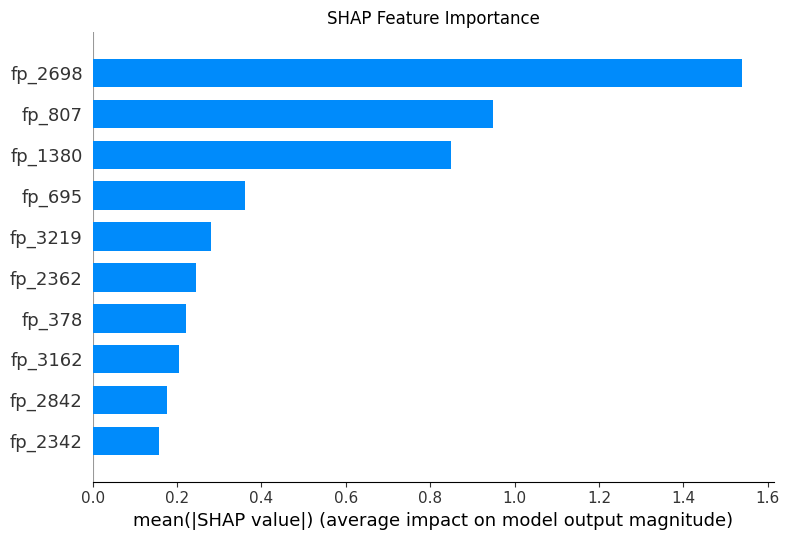

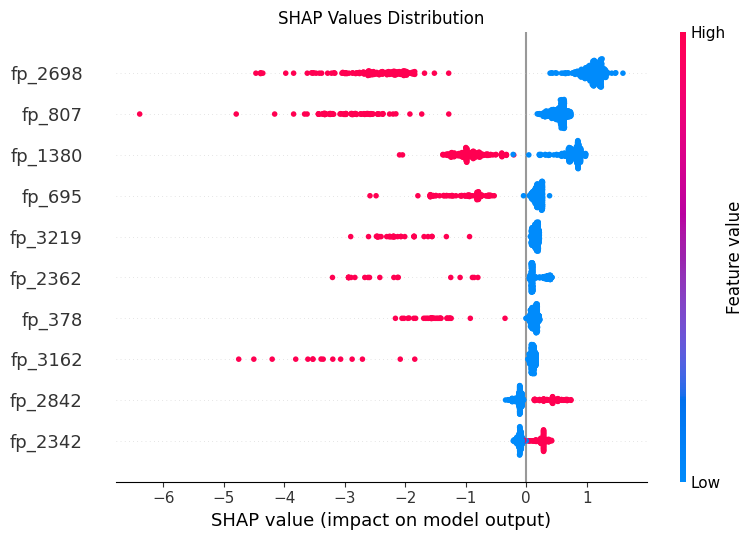

In [5]:
# Create explainer
xgb_explainer = shap.TreeExplainer(xgb_reg)

# Calculate SHAP values
xgb_explainer_values = xgb_explainer.shap_values(X_train)


create_shap(xgb_explainer_values, X_train, 10)


# Save SHAP values for later use
shap_df = pd.DataFrame(
    xgb_explainer_values,
    columns=X_train.columns
)

In [6]:
import numpy as np

# Method 1: Using shap.summary_plot
shap_values = xgb_explainer_values
feature_importance = np.abs(shap_values).mean(0)
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})
top_10_features = feature_importance_df.sort_values('importance', ascending=False).head(10)
top_10_features_list = list(top_10_features.index)

## Check fps

In [7]:
data_train = train_df[["label"]].copy()
data_train['smiles'] = data_train.index.values
data_train.head()

,label,smiles
CN(C)C(=O)c1ccc(cc1)OC,-9.625,CN(C)C(=O)c1ccc(cc1)OC
CC(C)C=C,2.452,CC(C)C=C
CCc1cnccn1,-5.809,CCc1cnccn1
CCCCCCCO,-2.917,CCCCCCCO
Cc1cc(cc(c1)O)C,-5.444,Cc1cc(cc(c1)O)C


In [20]:
from rdkit import Chem
from rdkit.Chem import AllChem

def get_morganfp_df(data,
                    smiles_col='smiles',
                    label_col='label',
                    radius = 2,
                    ) -> pd.DataFrame:
    """
    Funtion to calculate MorganFPs and return them as DF
    """
    # Use SMILES as index in df
    data_temp = data.set_index(smiles_col)

    # Temp dictionary to store data
    temp_dict = {}
    
    # List of SMILES fialed to convert to MOL
    failed_smiles = []

    # Set up fingerptint generator
    fpgen = AllChem.GetMorganGenerator(radius=radius,
                                       fpSize=4096)

    for smile in data_temp.index:
        temp_mol = Chem.MolFromSmiles(smile)
        if temp_mol:
            # Set up additional output to store bit info
            ao = AllChem.AdditionalOutput()
            ao.CollectBitInfoMap()
            fps = fpgen.GetFingerprint(temp_mol, additionalOutput=ao)
        else:
            failed_smiles.append(smile)
        
        temp_dict[smile] = {'morganfp':fps,
                            'bitinfo': ao.GetBitInfoMap(),
                            'mol': temp_mol,
                            'label': data_temp.loc[smile, label_col]}
    
    morganfp_df = pd.DataFrame.from_dict(temp_dict, orient='index')

    if len(failed_smiles) > 0:
        print(f'Warning: {len(failed_smiles)} SMILES failed to convert to mol')
    
    return morganfp_df

morganfp_train = get_morganfp_df(data_train)
morganfp_train.head()


,morganfp,bitinfo,mol,label
CN(C)C(=O)c1ccc(cc1)OC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{322: ((8, 1),), 695: ((11, 0),), 841: ((12, 1...",<rdkit.Chem.rdchem.Mol object at 0x7fa50b7a9a80>,-9.625
CC(C)C=C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{66: ((1, 2),), 1366: ((4, 0),), 2049: ((1, 0)...",<rdkit.Chem.rdchem.Mol object at 0x7fa50b7a9af0>,2.452
CCc1cnccn1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{378: ((4, 0), (7, 0)), 690: ((2, 2),), 724: (...",<rdkit.Chem.rdchem.Mol object at 0x7fa50b7a9e00>,-5.809
CCCCCCCO,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{541: ((5, 2),), 807: ((7, 0),), 1130: ((6, 2)...",<rdkit.Chem.rdchem.Mol object at 0x7fa50b7a9ee0>,-2.917
Cc1cc(cc(c1)O)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{807: ((7, 0),), 875: ((2, 1), (4, 1), (6, 1))...",<rdkit.Chem.rdchem.Mol object at 0x7fa50b7a9fc0>,-5.444


In [21]:
top_10_features_list

[2698, 807, 1380, 695, 3219, 2362, 378, 3162, 2842, 2342]

In [22]:
example_mols = {}

for feature in top_10_features_list:
    for i, index in enumerate(morganfp_train.index):
        if feature in morganfp_train.loc[index, 'bitinfo'].keys():
            example_mols[feature] = i
            break

example_mols

{2698: 0,
 807: 3,
 1380: 0,
 695: 0,
 3219: 40,
 2362: 54,
 378: 2,
 3162: 38,
 2842: 3,
 2342: 2}

In [39]:
import re
from rdkit.Chem import Draw

pattern = r'<rect style="opacity:1\.0;fill:#FFFFFF;stroke:none" width="150\.0" height="150\.0" x="0\.0" y="0\.0">\s*</rect>'

for bit, row in example_mols.items():

    test_mol = Chem.MolFromSmiles(morganfp_train.index[row])
    bit_info = morganfp_train.iloc[row,1]

    mfp_svg = Draw.DrawMorganBit(test_mol, bit, bit_info, useSVG=True)
    mfp_info = mfp_svg.data
    mfp_info = re.sub(pattern, '', mfp_info)


    with open(f'../plots/bits/bit_{bit}.svg', 'w') as f:
        f.write(mfp_info)



In [37]:
mfp_svg.data

'<svg xmlns="http://www.w3.org/2000/svg" xmlns:rdkit="http://www.rdkit.org/xml" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.1" baseProfile="full" xml:space="preserve" width="150px" height="150px" viewBox="0 0 150 150">\n<!-- END OF HEADER -->\n<rect style="opacity:1.0;fill:#FFFFFF;stroke:none" width="150.0" height="150.0" x="0.0" y="0.0"> </rect>\n<ellipse cx="21.6" cy="56.2" rx="14.1" ry="14.1" class="atom-0" style="fill:#9999E5;fill-rule:evenodd;stroke:#9999E5;stroke-width:1.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"/>\n<path class="bond-0 atom-0 atom-1" d="M 21.6,56.2 L 69.2,107.9" style="fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"/>\n<path class="bond-1 atom-1 atom-2" d="M 69.2,107.9 L 132.0,93.7" style="fill:none;fill-rule:evenodd;stroke:#E5E5E5;stroke-width:3.7px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"/>\n<path d="M 68.0,106.6 L 69.2,107.9 L 70.8,107.5"

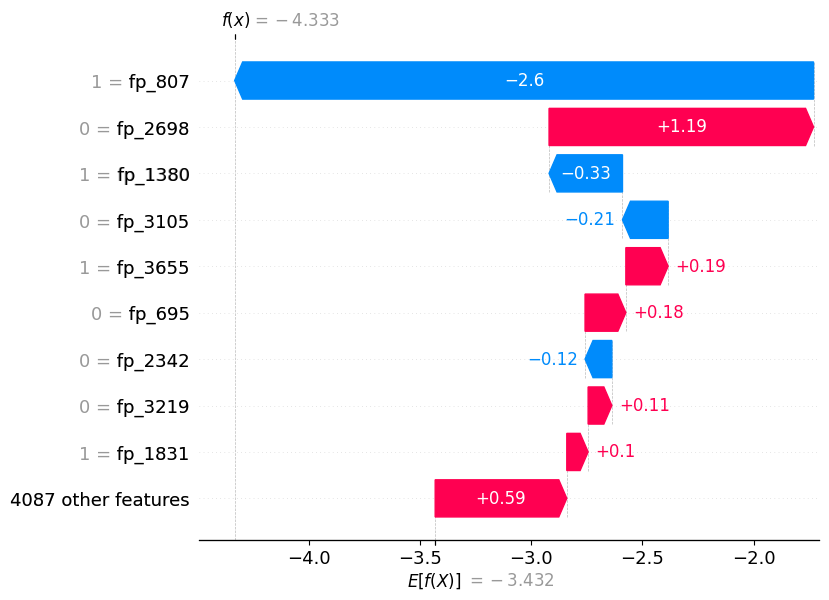

<Figure size 640x480 with 0 Axes>

In [12]:
# For a specific instance (e.g., row index 42)
instance_index = 42
plt.figure(figsize=(10, 6))
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[instance_index],
        base_values=xgb_explainer.expected_value,
        data=X_train.iloc[instance_index],
        feature_names=X_train.columns
    ),
    max_display=10
)
plt.tight_layout()
plt.show()

In [ ]:
mols = []

for i, index in enumerate(morganfp_train.index):
    if 2698 in morganfp_train.loc[index, 'bitinfo']:
        mols.append(i)

for row in mols[:10]:

    test_mol = Chem.MolFromSmiles(morganfp_train.index[row])
    bit_info = morganfp_train.iloc[row,1]

    mfp_svg = Draw.DrawMorganBit(test_mol, 2698, bit_info, useSVG=False)
    display(mfp_svg)

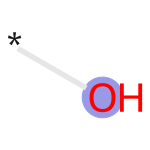

In [14]:
row = 42

bit = 807

test_mol = Chem.MolFromSmiles(morganfp_train.index[row])

bit_info = morganfp_train.iloc[row,1]

mfp_svg = Draw.DrawMorganBit(test_mol, bit, bit_info, useSVG=False)
display(mfp_svg)